In [168]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [169]:

songList = pd.read_csv( "/Users/stutiverma/Desktop/Plaksha/GITHUB/LyricsMatch_DataX1/lyrics_small.csv", index_col=0 )

songList = songList.replace({'\n': ' '}, regex=True)

songList

,year,artist,genre,lyrics
song,,,,
el-hijo-pra3digo,2007,avalanch,Metal,He visto un ro muerto He visto un ave caer He ...
till-we-earned-a-holiday,2007,the-anniversary,Rock,You're standing off the white church and you'r...
teenage-lament,2006,big-country,Rock,What a drag it is these gold lame' jeans Is th...
everyday,2006,en-vogue,Pop,"Sit down, let me tell you what's been on my mi..."
carolina-in-my-mind,2010,carole-king,Rock,In my mind I'm gone to Carolina Can't you see ...
...,...,...,...,...
living-water-bread-of-life,2006,4-him,Pop,"Like a deer, panting for the water I was thirs..."
human-thing,2008,be-good-tanyas,Country,Yer a human thing Who yah think that you're fo...
work-it,2002,50-cent,Hip-Hop,"[Busta Rhymes] There's only one God sonny, and..."


In [170]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stutiverma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [175]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/stutiverma/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [171]:
import re
from nltk.corpus import stopwords

def lyrics_cleaner(lyrics):
    
    # Extract only characters
    lyrics = re.sub("[^a-zA-Z]", " ", lyrics)
    
    # Tokenize into words (all lower case)
    lyrics = lyrics.lower().split()
    
    # Remove stopwords
    eng_stopwords = set(stopwords.words("english"))
    lyrics = [word for word in lyrics if not word in eng_stopwords]
    
    # Join the review to one sentence
    lyrics = ' '.join(lyrics)
    
    return lyrics

In [172]:
%%time

songList['lyrics'] = songList['lyrics'].apply(lyrics_cleaner)

songList

CPU times: user 9.41 s, sys: 1.62 s, total: 11 s
Wall time: 12.7 s


,year,artist,genre,lyrics
song,,,,
el-hijo-pra3digo,2007,avalanch,Metal,visto un ro muerto visto un ave caer visto un ...
till-we-earned-a-holiday,2007,the-anniversary,Rock,standing white church pitching three words yel...
teenage-lament,2006,big-country,Rock,drag gold lame jeans coolest way get though te...
everyday,2006,en-vogue,Pop,sit let tell mind day see thinking love share ...
carolina-in-my-mind,2010,carole-king,Rock,mind gone carolina see sunshine feel moonshine...
...,...,...,...,...
living-water-bread-of-life,2006,4-him,Pop,like deer panting water thirsting long dry set...
human-thing,2008,be-good-tanyas,Country,yer human thing yah think foolin yer foolin fo...
work-it,2002,50-cent,Hip-Hop,busta rhymes one god sonny replacement anybody...


In [173]:
import enchant
d = enchant.Dict("en_US")
word = "Bonjour"
d.check(word)

ModuleNotFoundError: No module named 'enchant'

In [177]:
import nltk
words = set(nltk.corpus.words.words())

" ".join(w for w in nltk.wordpunct_tokenize(songList['lyrics'][0]) \
         if w.lower() in words or not w.isalpha())
# 'Io to the beach with my'

'visto un visto un ave visto un mar tan negro visto visto un visto un padre hoy de mi el junto ti visto un visto un hoy visto tu hoy el es tan mi tan tu mi de'

In [146]:
songList_small = songList.sample(frac=0.1)

In [147]:
songList_small.info()
reindexed_data = songList_small['lyrics']

<class 'pandas.core.frame.DataFrame'>
Index: 2666 entries, lover-be-strong to can-t-wait-another-minute
Data columns (total 4 columns):
year      2666 non-null int64
artist    2666 non-null object
genre     2666 non-null object
lyrics    2666 non-null object
dtypes: int64(1), object(3)
memory usage: 104.1+ KB


In [148]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

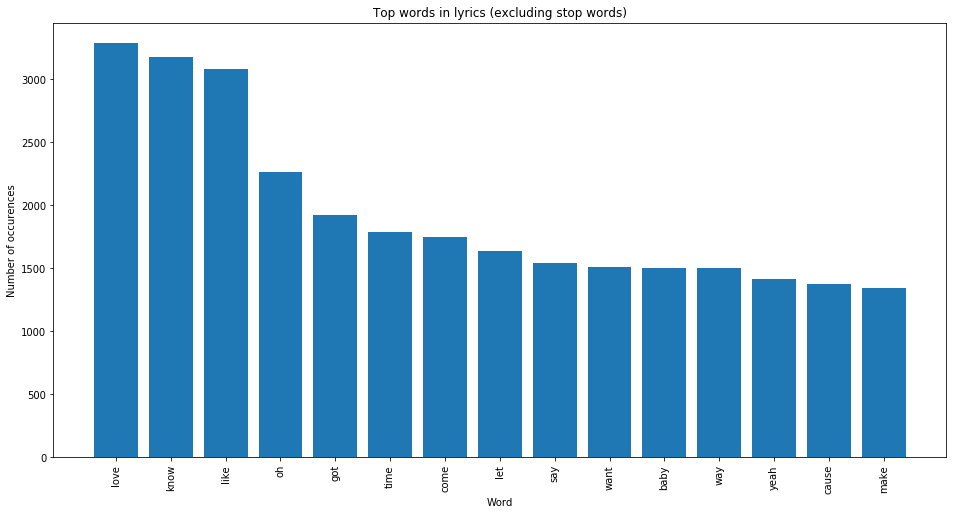

In [149]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(text_data=reindexed_data, count_vectorizer=count_vectorizer, n_top_words=15)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in lyrics (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [150]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stutiverma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [151]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/stutiverma/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [152]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [153]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per song: ', np.mean(word_counts))


Total number of words:  321408
Mean number of words per song:  120.55813953488372


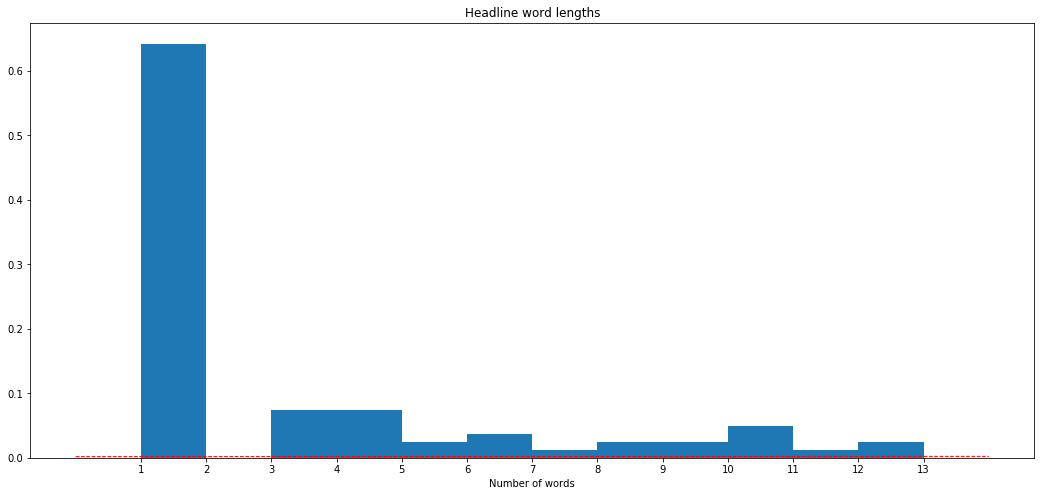

In [154]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

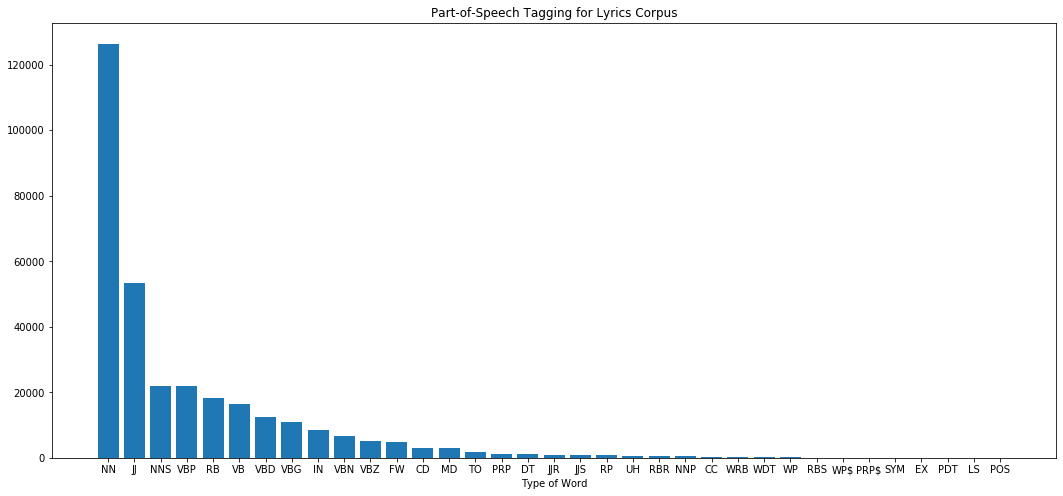

In [155]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Lyrics Corpus');
ax.set_xlabel('Type of Word');

In [156]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=1000, random_state=0).values

print('Lyrics before vectorization: \n{}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('\nLyrics after vectorization: \n{}'.format(small_document_term_matrix[123]))

Lyrics before vectorization: 
eleven days dozen nights thousand tears shoulder summer haze morning light sun rising like told fall never let spirit break call always soothe cries make slowly kiss dreams awake alone heavens sake mercury rising winter skies cold embrace shadows meet drag moonlight mine chase star rising beyond wonder fall never let spirit break call always soothe cries make slowly kiss dreams awake alone heavens sake mercury rising alone heaven sake tears run freely fears run deeply pressure breaking quicksilver awaking feel rise see rise droplets dreams touched disappear change weather wind hair mercury rising mercury rising rising rising mercury rising eleven days dozen nights thousand tears shoulder summer haze morning light sun rising like told

Lyrics after vectorization: 
  (0, 3174)	2
  (0, 12271)	2
  (0, 2452)	1
  (0, 15023)	1
  (0, 7981)	2
  (0, 13395)	3
  (0, 13727)	2
  (0, 7609)	2
  (0, 7519)	2
  (0, 11338)	2
  (0, 1546)	2
  (0, 4654)	2
  (0, 4766)	1
  (0, 759

In [157]:
n_topics = 8

In [158]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [159]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [160]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [161]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8')) 
        top_words.append(" ".join(topic_words))         
    return top_words

In [162]:
top_n_words_lsa = get_top_n_words(1, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  love
Topic 2:  que
Topic 3:  woo
Topic 4:  like
Topic 5:  du
Topic 6:  oh
Topic 7:  let
Topic 8:  gimme


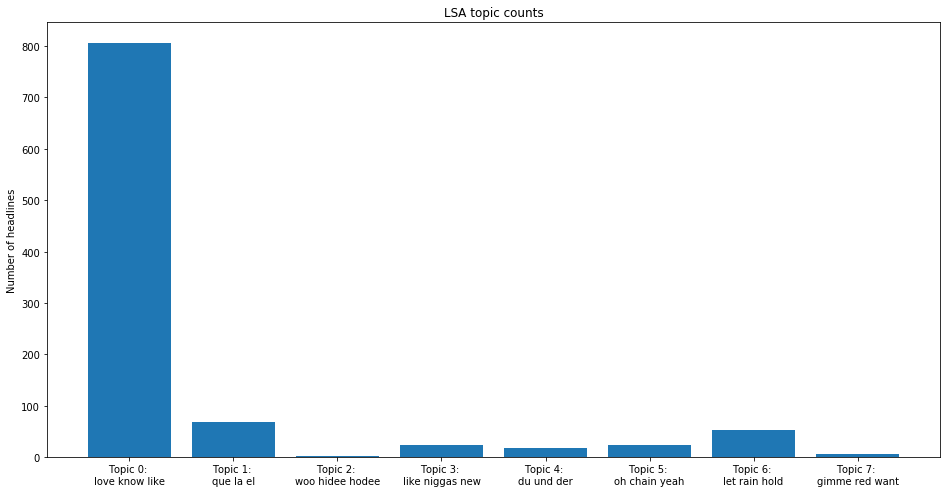

In [163]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [164]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.018s...
[t-SNE] Computed neighbors for 1000 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.564956
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.999630
[t-SNE] KL divergence after 2000 iterations: 0.619259


In [165]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [166]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [167]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)